# Classification of Satellite Image Time Series with Transformers

In this tutorial, we will investigate **transformer models for the classification of irregular satellite image time series**. You will reproduce methods, or at least variants, introduced in:
*Garnot, V. S. F., Landrieu, L., Giordano, S., & Chehata, N. (2020). Satellite image time series classification with pixel-set encoders and temporal self-attention. In Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition (pp. 12325-12334).*

As stated in the article by Garnot et al., "**crop type classification is a major challenge for agricultural and environmental policy makers**. In the European Union (EU), yearly crop maps are needed to grant the Common Agricultural Policy subsidies, an endowment of over 50 billion euros each year".

In order to automatically map the crop types, **multispectral satellite images have been extensively used** in the remote sensing community. In particular, the launch of the Sentinel-2 satellite by the European Space Agency in 2017, with a **high spectral resolution** (13 spectral channels from the visible to the short-wave infrared) and **short revisit time** (around 5 days), has open up new perspectives for analysing crop phenology (Garnot et al., 2020).

Link to (Garnot et al., 2020): https://arxiv.org/pdf/1911.07757

More information about the Sentinel-2 mission: https://www.cesbio.cnrs.fr/multitemp/sentinel-2/#English

### Structure of the repo

The code for running this tutorial is available at https://github.com/Romain3Ch216/DL4IA/tree/main/docs/tutorials/sits_classification. We suggest to fork the [DL4IA](https://github.com/Romain3Ch216/DL4IA) repo and clone your fork:
```
git clone git@github.com:<your-username>/DL4IA.git

```

The repo contains the following files, with code **to be completed**.
```
sits_classification
├── configs
    ├── default.yaml
    ├── ...
├── models
    ├── transformer
        ├── attention.py
        ├── layers.py
        ├── transformer.py
    ├── classifiers.py
├── utils
    ├── focal_loss.py
    ├── utils.py
├── dataset.py
├── eval.py
├── sits_classification.ipynb
├── train.py
```

### The Sentinel-2 data

First of all, let's visualize some Sentinel-2 images! Below, we show **RGB compositions** of the first 10 images of a Sentinel-2 time series. The images, taken from the [PASTIS](https://zenodo.org/records/5012942) data set, were preprocessed by an **atmospheric correction code** that converted the raw signal into **bottom-of-atmosphere reflectance**. The spatial resolution of the images spans from 10m to 60m, depending on the wavelength. Here, every channels were resampled at a 10m resolution.

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

from utils.utils import rgb_render

In [3]:
data_folder = "s2_agri_pixel_set"

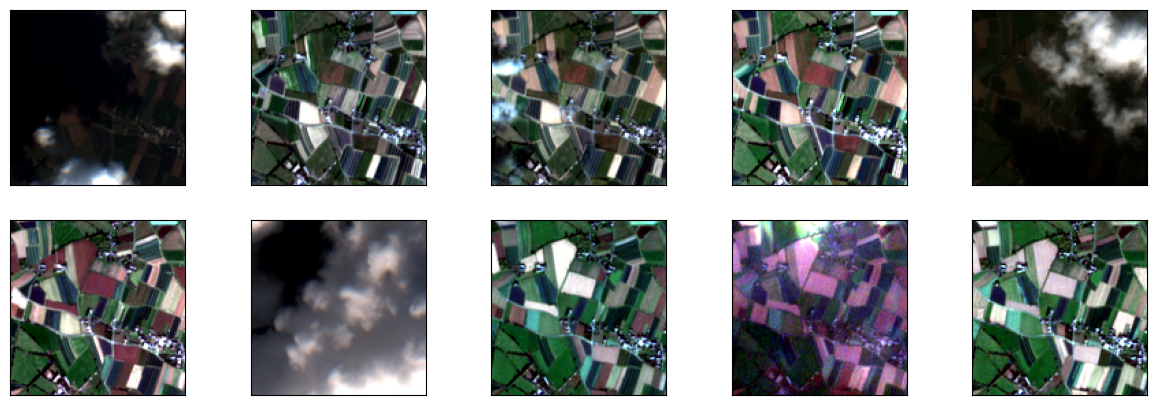

In [4]:
patch = np.load(os.path.join(data_folder, "patch_ts.npy"))
rgb_bands = [2, 1, 0]

fig, ax = plt.subplots(2, 5, figsize=(15, 5))
for l in range(10):
    img, _, _ = rgb_render(patch[l], bands=rgb_bands)
    ax[l // 5, l % 5].imshow(img)
    ax[l // 5, l % 5].set_xticks([])
    ax[l // 5, l % 5].set_yticks([])
plt.show()

As you can see, at some dates, **the cloud cover makes the data useless** for crop type classification. A preprocessing algorithm could discard those images, resulting in clean but heteregoneous image time series. In order to process time series of varying lengths with traditional machine learning methods, the homogeneization of the time series with interpolation methods would be necessary. In contrast, **Transformers are suited to handle time series of different lengths**. 

### Pixel-Set Encoders and Temporal Self-Attention (Garnot et al., 2020)

In the following, we will consider variants of the pixel-set encoder and temporal self-attention introduced in (Garnot et al., 2020). Garnot et  al. argue that **"convolutions may not be well-suited for the analysis of medium-resolution satellite images of agricultural parcels"** as they struggle to capture textural information. Besides, "efficiently training CNNs requires organizing the data into batches of images of identical dimensions. The irregular size of the parcels makes this process very memory intensive". 

Therefore, Garnot et al. suggest to **process parcels as a set of randomly sampled pixels**. For each image in the time series, they compute features from the set of pixel, resulting in a sequence of features / embeddings, that are inputs to a Transformer, as illustred below.

<center>
  <img src="garnot_2020.png" alt="Schematic view of the pixel-set encoder and temporal self-attention" width=800>
</center>
<center>
    <em>Schematic view of the pixel-set encoder and temporal self-attention. Source: (Garnot et al., 2020).</em>
</center>

### Sentinel-2 pixel time series

From now on, we consider Sentinel-2 time series in the Pixel-Set format, *i.e.* (n_dates x n_channels x n_pixels). For this tutorial, we provide a subset of the [S2-Agri Pixel-Set](https://zenodo.org/records/5815488) data set. The original data set actually comprises fixed-length time series without cloud cover, but we artificially created irregularity for the purpose of this tutorial.

In [5]:
import torch
from utils.utils import dates2doys, fill_ts

In [6]:
# Load time series and associated days of year (DOY)
ts1 = torch.load(os.path.join(data_folder, 'data', 'sample_0.pt'))
ts2 = torch.load(os.path.join(data_folder, 'data', 'sample_1.pt'))
print(ts1.shape)

doy1 = torch.load(os.path.join(data_folder, 'data', 'doy_0.pt'))
doy2 = torch.load(os.path.join(data_folder, 'data', 'doy_1.pt'))
print(doy1)
print(doy1.shape)

days = np.load(os.path.join(data_folder, 'days.npy'))
doys = dates2doys(days)
print(doys)
# Convert digital numbers to reflectance
quantification_value = 10000
ts1 /= quantification_value
ts2 /= quantification_value

# Fill missing dates with NaN 
ts1 = fill_ts(ts1, doy1, doys)
ts2 = fill_ts(ts2, doy1, doys)
print(ts1.shape)    # 24 ! instead of 17 

# Compute mean over pixels
mean_ts1 = torch.mean(ts1, dim=-1)
mean_ts2 = torch.mean(ts2, dim=-1)

torch.Size([17, 10, 64])
tensor([ 33, 104, 143, 163, 182, 192, 202, 212, 222, 227, 246, 266, 275, 280,
        290, 310, 315])
torch.Size([17])
tensor([ 33,  43,  72, 104, 123, 143, 163, 182, 192, 202, 212, 217, 222, 227,
        232, 246, 261, 266, 275, 280, 290, 305, 310, 315])
torch.Size([24, 10, 64])


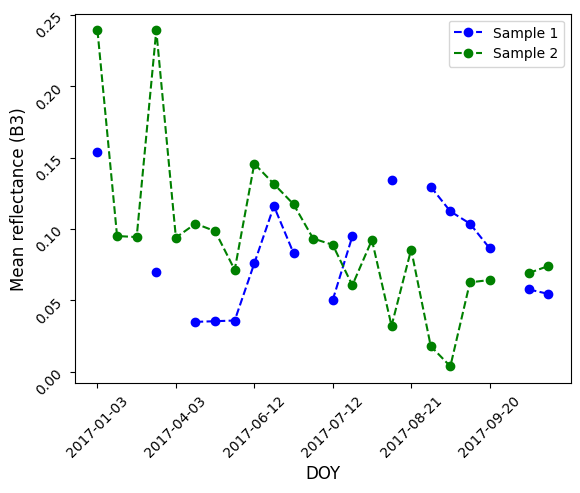

In [7]:
fig, ax = plt.subplots()
ind_dates = list(range(0, len(days), 4))
fontsize = 12

plt.plot(mean_ts1[:, 2], '--bo', label='Sample 1')
plt.plot(mean_ts2[:, 2], '--go', label='Sample 2')
ax.set_xticks(ind_dates)
ax.set_xticklabels(days[ind_dates])
plt.tick_params(rotation=45)
plt.ylabel("Mean reflectance (B3)", fontsize=fontsize)
plt.xlabel("DOY", fontsize=fontsize)
plt.legend()
plt.show()
# plot mean reflectance on pixels, channel 2, all doys
# we can visualize the missing data

### Adaptation of a "traditional" Transformer to the classification of satellite image time series

In this tutorial, we will start from a PyTorch implementation of the Transformer, introduced in [(Vaswani et al. 2017)](https://proceedings.neurips.cc/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf), available at: <br> https://github.com/jadore801120/attention-is-all-you-need-pytorch/.

The goal is to adapt the Transformer architecture, following modifications introduced in (Garnot et al., 2020). 

**Positional Encoding** First, in order to "account for inconsistent temporal sampling", Garnot et al. modify the conventional positional encoding in Transformers (see eq. 4 in the paper). *Update the `PositionalEncoding` class in models/transformer/layers.py.*

*Plot the similarity between the positional encodings of ts1 and ts2. What is the influence of the parameter T?*

In [8]:
from models.transformer.layers import PositionalEncoding

In [9]:
pos_encoding=PositionalEncoding(d_hid=64)

In [10]:
pos_encoding.pos_table.shape

torch.Size([1, 365, 64])

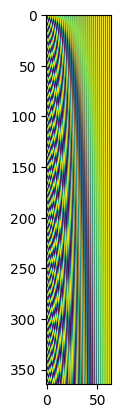

In [11]:
plt.imshow(pos_encoding.pos_table[0])
# une ligne = un embedding 

In [12]:
#TODO: compute the similarity matrix between the positional encodings.

pos_emb1=pos_encoding(doy1)
print(pos_emb1.shape)

pos_emb2=pos_encoding(doy2)
print(pos_emb2.shape)

pos_emb1=pos_emb1/torch.linalg.norm(pos_emb1,dim=-1).unsqueeze(-1)
pos_emb2=pos_emb2/torch.linalg.norm(pos_emb2,dim=-1).unsqueeze(-1)

sim=torch.matmul(pos_emb1.squeeze(0),pos_emb2.squeeze(0).T)
print(sim.shape)

torch.Size([1, 17, 64])
torch.Size([1, 23, 64])
torch.Size([17, 23])


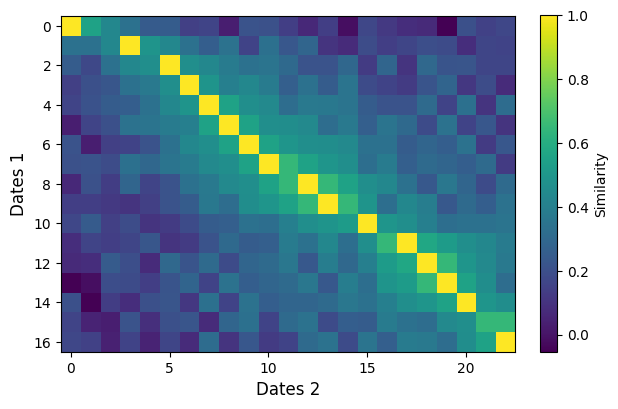

In [13]:
# similarity of positionnal encodings of 2 DOYS 
fig = plt.figure()
fontsize = 12
plt.imshow(sim)
plt.colorbar(label='Similarity', fraction=0.034)
plt.xlabel('Dates 2', fontsize=fontsize)
plt.ylabel('Dates 1', fontsize=fontsize)
plt.show()

In [14]:
from dataset import PixelSetData
dataset=PixelSetData(data_folder)

In [15]:
len(dataset)

30000

In [16]:
sample,doys,label=dataset.__getitem__(100)

In [21]:
print(sample.shape)
print(doys)
print(label)

torch.Size([18, 10, 64])
tensor([[ 33,  72, 104, 143, 163, 182, 192, 212, 217, 227, 232, 246, 261, 275,
         290, 310,   0,   0,   0,   0,   0,   0,   0],
        [ 72, 104, 123, 143, 163, 182, 192, 202, 212, 217, 222, 227, 232, 246,
         261, 266, 275, 280, 305, 310, 315,   0,   0],
        [ 33,  43,  72, 104, 123, 143, 163, 182, 192, 202, 212, 217, 222, 227,
         232, 246, 261, 266, 275, 280, 290, 310, 315],
        [ 33, 104, 123, 143, 163, 182, 192, 202, 212, 227, 232, 246, 261, 266,
         275, 290, 305, 310, 315,   0,   0,   0,   0]])
tensor(2)


Comment marche le dataloader de dataset.py : 

In [22]:
from torch.utils.data import DataLoader
from dataset import Padding

padding=Padding(pad_value=0)

train_data_loader=torch.utils.data.DataLoader(
    dataset,
    collate_fn=padding.pad_collate, # ajoute du padding pour que toutes series temp aient la même longueur DANS LE même BATCH 
    batch_size=4,
    shuffle=True,
)

In [23]:
samples,doys,labels=next(iter(train_data_loader))
print(samples.shape)
print(doys.shape)
print(labels.shape)
print(doys[0]) # on voit bien le padding

torch.Size([4, 20, 10, 64])
torch.Size([4, 20])
torch.Size([4])
tensor([ 43,  72, 123, 143, 163, 192, 202, 222, 232, 246, 275, 280, 290, 305,
        310, 315,   0,   0,   0,   0])


In [20]:
samples[0, 23].sum()

IndexError: index 23 is out of bounds for dimension 1 with size 23

In [24]:
from models.transformer.layers import EmbeddingLayer

emb_layer=EmbeddingLayer(n_channels=10,n_pixels=64,d_model=64)
emb_layer(samples).shape    # (4, seq_len, 64) : chaque date est représentée par un embedding de dimension 64

torch.Size([4, 20, 64])

In [28]:
# petit test
from models.transformer.layers import Temporal_Aggregator

emb = emb_layer(samples)
print(emb.shape)

pos = pos_encoding(doys)
print(pos.shape)

emb = emb + pos
print(emb.shape)

mask = (doys != 0).float()  # 1 when diff 0, 0 either
temporal_agg=Temporal_Aggregator()
out = temporal_agg(emb, mask)

print(out.shape)


torch.Size([4, 20, 64])
torch.Size([4, 20, 64])
torch.Size([4, 20, 64])
torch.Size([4, 64])


**Embedding and Temporal Aggregator Layers** Instead of the pixel-set encoder, we will use an `EmbeddingLayer`that computes d-dimensional embeddings from the pixel-set data, through a dense layer with a non-linearity. 

*First, update the `PixelSetData` class in `dataset.py`, that will allow the creation of a PyTorch dataset suited for mini-batch optimization.*

*Second, update the `EmbeddingLayer` class in models/transformer/layers.py, as well as the required scripts in order to train and test the model. In particular, Garnot et al. aim to extract only one embedding from the time series, rather than a sequence of embeddings. Here, we will compute the average of the embeddings through a `Temporal_Aggregator`.* 

We will denote this version of the model as the *default* version. *Show the test metrics and display the confusion matrix.*


**Master Query** Another approach introduced in (Garnot et al., 2020) in order to compute a single embedding from the time series is to use a single master query. While they compute the master query as "a temporal average of the queries of all dates", we will use a variant introduced in another paper of the authors that we will refer as the learnable query. Instead of computing the query from the data, the idea is to learn a single master query.

*Starting from the `MultiHeadAttention` class, update the `LearnableQueryMultiHeadAttention` class in models/transformer/attention.py*.

*Show the test metrics and display the confusion matrix. Compare the performance, number of parameters and FLOPs with the default version.*

| Model | Test accurarcy | Test F1 score | Nb parameters | FLOPs |
| --- | --- | --- | --- | --- |
| Default | | | | |
| Single Query | | | | |

*Finally, compute and display the mean attention for the classes of Spring Cereal and Summer cereal.*

In [10]:
import yaml
import matplotlib.patches as mpatches

from models.transformer.transformer import Transformer
from dataset import PixelSetData, Padding
from utils import mean_attention

In [11]:
with open(os.path.join(results_folder, 'train_config.yaml'), 'r') as file:
    cfg = yaml.safe_load(file)
    
encoder = Transformer(
    n_channels=cfg['n_channels'],
    n_pixels=cfg['n_pixels'],
    d_model=cfg['d_model'],
    d_inner=cfg['d_inner'],
    n_head=cfg['n_head'],
    d_k=cfg['d_k'],
    d_v=cfg['d_v'],
    dropout=cfg['dropout'],
    pad_value=cfg['pad_value'],
    scale_emb_or_prj=cfg['scale_emb_or_prj'],
    n_position=cfg['pos_embedding']['n_position'],
    T=cfg['pos_embedding']['T'],
    return_attns=True,
    learnable_query=cfg['learnable_query'],
    spectral_indices_embedding=cfg['spectral_indices'],
    channels=cfg['channels'],
    compute_values=cfg['compute_values']
)

if cfg['device'] == 'cuda' and torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

encoder = encoder.to(device)
checkpoint = torch.load(os.path.join(results_folder, 'best_model.pth.tar'), map_location=device)
encoder.load_state_dict(checkpoint['encoder'])
del checkpoint

encoder.eval()

Transformer(
  (embedding): EmbeddingLayer(
    (embedding): Conv1d(10, 64, kernel_size=(64,), stride=(1,))
  )
  (layer_stack): ModuleList(
    (0): EncoderLayer(
      (slf_attn): LearnableQueryMultiHeadAttention(
        (w_ks): Linear(in_features=64, out_features=256, bias=False)
        (w_vs): Linear(in_features=64, out_features=256, bias=False)
        (fc): Linear(in_features=256, out_features=64, bias=False)
        (attention): ScaledDotProductAttention(
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (dropout): Dropout(p=0, inplace=False)
        (layer_norm): LayerNorm((64,), eps=1e-06, elementwise_affine=True)
      )
      (pos_ffn): PositionwiseFeedForward(
        (w_1): Linear(in_features=64, out_features=64, bias=True)
        (w_2): Linear(in_features=64, out_features=64, bias=True)
        (layer_norm): LayerNorm((64,), eps=1e-06, elementwise_affine=True)
        (dropout): Dropout(p=0, inplace=False)
      )
    )
  )
  (temporal_aggregator): T

In [12]:
test_dataset = PixelSetData(cfg['data_folder'], set='test')

attns_class_1 = mean_attention(encoder, test_dataset, select_class=1)
attns_class_2 = mean_attention(encoder, test_dataset, select_class=2)

Test: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18997/18997 [00:10<00:00, 1773.29it/s]


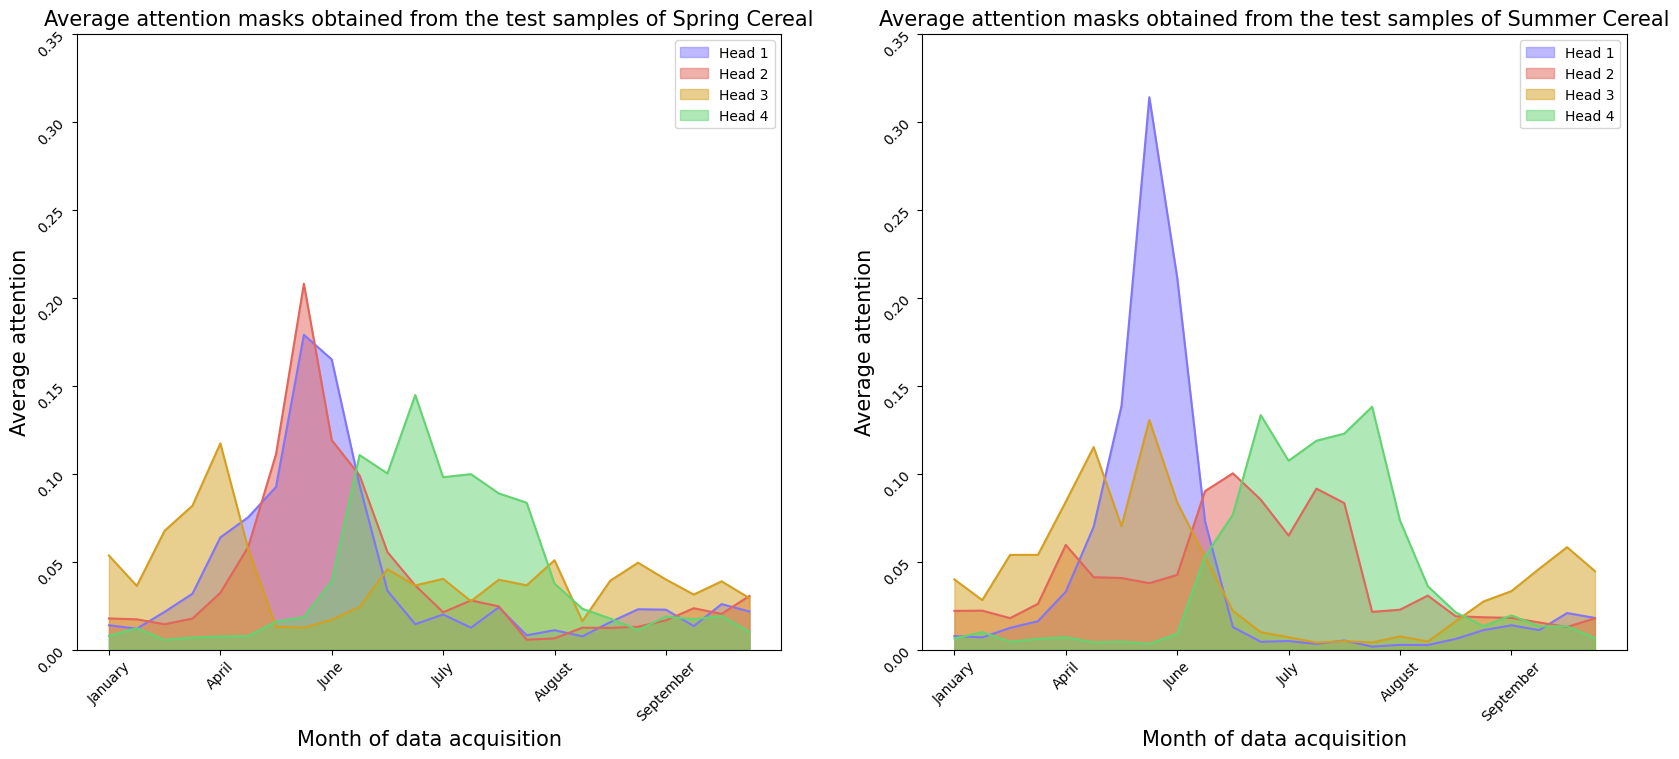

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
fontsize = 15
colors = [
    "#8075ff",
    "#e3655b",
    "#D5A021",
    "#63d471"
]
patches = [
    mpatches.Patch(color=colors[i], alpha=0.5, label=f'Head {i+1}') for i in range(cfg['n_head'])
]
ind_dates = list(range(0, len(days), 4))
x_values = list(range(0, len(days)))

for i in range(attns_class_1.shape[0]):
    ax[0].plot(attns_class_1[i], color=colors[i])
    ax[0].fill_between(x=x_values, y1=attns_class_1[i], color=colors[i], alpha=0.5)

    ax[1].plot(attns_class_2[i], color=colors[i])
    ax[1].fill_between(x=x_values, y1=attns_class_2[i], color=colors[i], alpha=0.5)

for j in [0, 1]:
    ax[j].set_xticks(ind_dates)
    ax[j].set_xticklabels(['January', 'April', 'June', 'July', 'August', 'September'])
    ax[j].set_ylim(0, 0.35)
    ax[j].legend(handles=patches)
    ax[j].tick_params(rotation=45)
    ax[j].set_ylabel("Average attention", fontsize=fontsize)
    ax[j].set_xlabel("Month of data acquisition", fontsize=fontsize)
ax[0].set_title('Average attention masks obtained from the test samples of Spring Cereal', fontsize=fontsize)
ax[1].set_title('Average attention masks obtained from the test samples of Summer Cereal', fontsize=fontsize)
    
plt.show()

**Hand-crafted embeddings** Now, we assume that we know, from expert knowledge, that some spectral indices (normalized linear combination of spectral channels) are discriminative features for crop type classification. In particular, we want to compute features based on the Normalized Difference Vegetation Index (NDVI) and Bare Soil Index (BI) defined as follows:
$$
NDVI = \frac{NIR - RED}{NIR + RED},
$$
and 
$$
BI = \frac{(SWIR1 + RED) - (NIR + BLUE)}{(SWIR1 + RED) + (NIR + BLUE)}.
$$

*Update the `NDVI`, `BI`, and `SpectralIndicesLayer` classes in models/transformer/layers.py. Plot the mean NDVI time series for ts1 and ts2.*

In [21]:
from models.transformer.layers import NDVI

In [22]:
#TODO: compute mean ndvi of ts1 and ts2

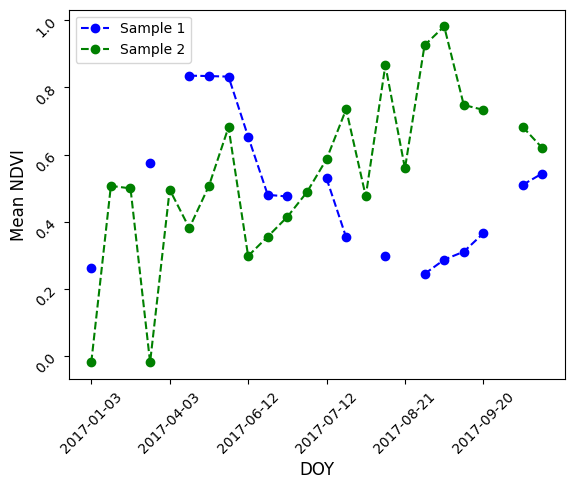

In [23]:
fig, ax = plt.subplots()
ind_dates = list(range(0, len(days), 4))
fontsize = 12

plt.plot(ndvi_mean_1, '--bo', label='Sample 1')
plt.plot(ndvi_mean_2, '--go', label='Sample 2')
ax.set_xticks(ind_dates)
ax.set_xticklabels(days[ind_dates])
plt.tick_params(rotation=45)
plt.ylabel("Mean NDVI", fontsize=fontsize)
plt.xlabel("DOY", fontsize=fontsize)
plt.legend()
plt.show()

We will use the `SpectralIndicesLayer` as the embedding layer. *Train and test this new version of the model. Compare the performance, number of parameters and FLOPs with the previous versions*.

| Model | Test accurarcy | Test F1 score | Nb parameters | FLOPs |
| --- | --- | --- | --- | --- |
| Default | | | | |
| Single Query | | | | |
| Spectral Indices | | | | |